In [1]:
from fastai.vision.all import *
# from utils import *

# Non-branch

In [2]:
path = Path(untar_data(URLs.CIFAR))

In [3]:
path.ls()

(#3) [Path('/root/.fastai/data/cifar10/test'),Path('/root/.fastai/data/cifar10/labels.txt'),Path('/root/.fastai/data/cifar10/train')]

In [4]:
def custom_is_valid(o):
    return Path(o).parent.parent.name == 'test'

In [5]:
data = DataBlock(blocks = (ImageBlock, CategoryBlock),
                splitter=FuncSplitter(custom_is_valid),
                get_items=get_image_files,
                get_y=parent_label,
                item_tfms=Resize(224))
dls = data.dataloaders(path)

In [6]:
dls.train_ds, dls.valid_ds

((#50000) [(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4))...],
 (#10000) [(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size

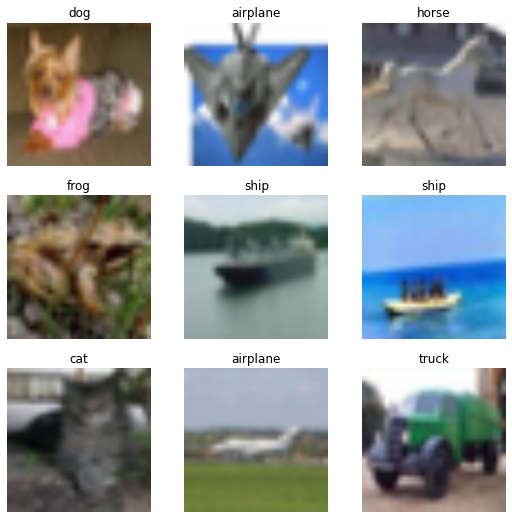

In [7]:
dls.show_batch(nrows=3, ncols=3)

In [8]:
class VGGCustomModel(Module):
    def __init__(self, encoder, head):
        self.encoder = encoder
        self.head = head
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.head(x)
        return x

In [9]:
def custom_splitter(model):
    return [params(model.encoder),
            params(model.head)]

In [10]:
model = vgg16_bn
body = create_body(model, cut=-2)
head = create_head(512*2,dls.c)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [11]:
model = VGGCustomModel(body, head)

In [12]:
data = DataBlock(blocks = (ImageBlock, CategoryBlock),
                splitter=FuncSplitter(custom_is_valid),
                get_items=get_image_files,
                get_y=parent_label,
                item_tfms=Resize(224))
dls = data.dataloaders(path)

In [13]:
dls.train_ds, dls.valid_ds

((#50000) [(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4))...],
 (#10000) [(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size=32x32, TensorCategory(4)),(PILImage mode=RGB size

In [14]:
dls.vocab

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [15]:
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy,
                   splitter=custom_splitter).to_fp16()
learn.freeze()

In [16]:
learn.summary()

VGGCustomModel (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 224 x 224  1,792      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 224 x 224  128        True      
________________________________________________________________
ReLU                 64 x 64 x 224 x 224  0          False     
________________________________________________________________
Conv2d               64 x 64 x 224 x 224  36,928     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 224 x 224  128        True      
________________________________________________________________
ReLU                 64 x 64 x 224 x 224  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 112 x 112  0          False     
_____________________________________________

In [17]:
learn.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.373568,0.276678,0.902400,02:16


In [18]:
learn.unfreeze()
learn.fit_one_cycle(40, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.303283,0.274010,0.903200,02:48
1,0.301234,0.271425,0.902500,02:48
2,0.289694,0.267933,0.904000,02:49
3,0.287994,0.264488,0.907900,02:48
4,0.274380,0.256555,0.909200,02:49
5,0.250111,0.248243,0.911500,02:48
6,0.238691,0.245080,0.914500,02:49
7,0.227742,0.238066,0.916600,02:48
8,0.218408,0.233154,0.919500,02:49
9,0.196960,0.228135,0.921100,02:49


In [19]:
learn.save('nobranch-fepochs1-uepochs40')

Path('models/nobranch-fepochs1-uepochs40.pth')

# Branch-CNN

In [7]:
from torchvision.models.utils import load_state_dict_from_url

In [8]:
cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}


def _vgg(arch, cfg, batch_norm, pretrained, progress, **kwargs):
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)
    if True:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

def vgg16_bn(pretrained=False, progress=True, **kwargs):
    r"""VGG 16-layer model (configuration "D") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16_bn', 'D', True, pretrained, progress, **kwargs)

In [9]:
model = vgg16_bn
body = create_body(model, cut=-2)
body

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [10]:
head = create_head(512*2,dls.c)
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=10, bias=False)
)

In [11]:
_body = body[0]
block1 = _body[:7]
block2 = _body[7:14]
block3 = _body[14:24]
block4 = _body[24:34]
block5 = _body[34:]

In [12]:
# CIFAR_100
# def custom_get_y(o):
#     return [Path(o).parent.name, Path(o).parent.parent.name]


coarse1 = {
    'airplane': 'transport',
    'ship': 'transport',
    'automobile': 'transport',
    'truck': 'transport',
    'bird': 'animal',
    'frog': 'animal',
    'cat': 'animal',
    'dog': 'animal',
    'deer': 'animal',
    'horse': 'animal'
}

coarse2 = {
    'airplane': 'sky',
    'ship': 'water',
    'automobile': 'road',
    'truck': 'road',
    'bird': 'bird',
    'frog': 'reptile',
    'cat': 'pet',
    'dog': 'pet',
    'deer': 'medium',
    'horse': 'medium'
}

def custom_get_y(o):
    fine_label = Path(o).parent.name
    coarse1_label = coarse1[fine_label]
    coarse2_label = coarse2[fine_label]
    return [coarse2_label, coarse1_label, fine_label]

In [13]:
class VGGCustomModel(Module):
    def __init__(self, encoder, head):
        self.encoder = encoder
        encoder = encoder[0]
        self.block1 = encoder[:7]
        self.block2 = encoder[7:14]
        self.branch1 = create_head(128*2, len(set(coarse1.values())))
        self.block3 = encoder[14:24]
        self.branch2 = create_head(256*2, len(set(coarse2.values())))
        self.block4 = encoder[24:34]
        self.block5 = encoder[34:]
        self.head = head
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        coarse1_label = self.branch1(x)
        x = self.block3(x)
        coarse2_label = self.branch2(x)
        x = self.block4(x)
        x = self.block5(x)
        fine_label = self.head(x)
        return {
                'fine_label': fine_label,
                'coarse2_label': coarse2_label,
                'coarse1_label': coarse1_label
               }

In [14]:
def loss_func(out, targ):
    return nn.CrossEntropyLoss()(out['fine_label'], targ['fine_label']) + \
            nn.CrossEntropyLoss()(out['coarse2_label'], targ['coarse2_label']) + \
            nn.CrossEntropyLoss()(out['coarse1_label'], targ['coarse1_label'])

In [15]:
# def custom_accuracy(inp, targ, axis=-1):
#     pred1,targ1 = flatten_check(inp['label1'].argmax(dim=axis), targ['label1'])
#     acc1 = (pred1 == targ1).float().mean()
#     pred2,targ2 = flatten_check(inp['label2'].argmax(dim=axis), targ['label2'])
#     acc2 = (pred2 == targ2).float().mean()
#     return (acc1+acc2)/2

def custom_accuracy(inp, targ, axis=-1):
    pred1,targ1 = flatten_check(inp['fine_label'].argmax(dim=axis), targ['fine_label'])
    acc1 = (pred1 == targ1).float().mean()
    return acc1

In [16]:
model = VGGCustomModel(body, head)

In [17]:
class CustomCategorize(DisplayedTransform):
    "Reversible transform of category string to `vocab` id"
    loss_func,order=CrossEntropyLossFlat(),1
    def __init__(self, vocab=None, vocab_coarse1=None, vocab_coarse2=None, sort=True, add_na=False, num_y=1):
        store_attr()
        self.vocab = None if vocab is None else CategoryMap(vocab, sort=sort, add_na=add_na)
        self.vocab_coarse1 = None if vocab_coarse1 is None else CategoryMap(vocab_coarse1, sort=sort, add_na=add_na)
        self.vocab_coarse2 = None if vocab_coarse2 is None else CategoryMap(vocab_coarse2, sort=sort, add_na=add_na)

    def setups(self, dsets):
        fine_dsets = [d[2] for d in dsets]
        coarse1_dsets = [d[1] for d in dsets]
        coarse2_dsets = [d[0] for d in dsets]
        if self.vocab is None and dsets is not None: self.vocab = CategoryMap(fine_dsets, sort=self.sort, add_na=self.add_na)
        if self.vocab_coarse1 is None and dsets is not None: self.vocab_coarse1 = CategoryMap(coarse1_dsets, sort=self.sort, add_na=self.add_na)
        if self.vocab_coarse2 is None and dsets is not None: self.vocab_coarse2 = CategoryMap(coarse2_dsets, sort=self.sort, add_na=self.add_na)
        self.c = len(self.vocab)

    def encodes(self, o): return {'fine_label': TensorCategory(self.vocab.o2i[o[2]]),
                                  'coarse1_label': TensorCategory(self.vocab_coarse1.o2i[o[1]]),
                                  'coarse2_label': TensorCategory(self.vocab_coarse2.o2i[o[0]])
                                 }
    def decodes(self, o): return Category      (self.vocab    [o])

In [18]:
def CustomCategoryBlock(vocab=None, sort=True, add_na=False, num_y=1):
    "`TransformBlock` for single-label categorical targets"
    return TransformBlock(type_tfms=CustomCategorize(vocab=vocab, sort=sort, add_na=add_na))

In [19]:
def custom_splitter(model):
    return [params(model.block1),
            params(model.block2),
            params(model.block3),
            params(model.block4),
            params(model.block5),
            params(model.head)]

In [20]:
data = DataBlock(blocks = (ImageBlock, CustomCategoryBlock),
                splitter=FuncSplitter(custom_is_valid),
                get_items=get_image_files,
                get_y=custom_get_y,
                item_tfms=Resize(224))
dls = data.dataloaders(path)

In [21]:
dls.train_ds, dls.valid_ds

((#50000) [(PILImage mode=RGB size=32x32, {'fine_label': TensorCategory(4), 'coarse1_label': TensorCategory(0), 'coarse2_label': TensorCategory(1)}),(PILImage mode=RGB size=32x32, {'fine_label': TensorCategory(4), 'coarse1_label': TensorCategory(0), 'coarse2_label': TensorCategory(1)}),(PILImage mode=RGB size=32x32, {'fine_label': TensorCategory(4), 'coarse1_label': TensorCategory(0), 'coarse2_label': TensorCategory(1)}),(PILImage mode=RGB size=32x32, {'fine_label': TensorCategory(4), 'coarse1_label': TensorCategory(0), 'coarse2_label': TensorCategory(1)}),(PILImage mode=RGB size=32x32, {'fine_label': TensorCategory(4), 'coarse1_label': TensorCategory(0), 'coarse2_label': TensorCategory(1)}),(PILImage mode=RGB size=32x32, {'fine_label': TensorCategory(4), 'coarse1_label': TensorCategory(0), 'coarse2_label': TensorCategory(1)}),(PILImage mode=RGB size=32x32, {'fine_label': TensorCategory(4), 'coarse1_label': TensorCategory(0), 'coarse2_label': TensorCategory(1)}),(PILImage mode=RGB size

In [22]:
dls.vocab, dls.vocab_coarse1, dls.vocab_coarse2

(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
 ['animal', 'transport'],
 ['bird', 'medium', 'pet', 'reptile', 'road', 'sky', 'water'])

In [23]:
learn = Learner(dls, model, loss_func=loss_func, metrics=custom_accuracy,
                   splitter=custom_splitter).to_fp16()
learn.freeze()

In [24]:
learn.summary()

VGGCustomModel (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 224 x 224  1,792      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 224 x 224  128        True      
________________________________________________________________
ReLU                 64 x 64 x 224 x 224  0          False     
________________________________________________________________
Conv2d               64 x 64 x 224 x 224  36,928     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 224 x 224  128        True      
________________________________________________________________
ReLU                 64 x 64 x 224 x 224  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 112 x 112  0          False     
_____________________________________________

In [25]:
learn.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,custom_accuracy,time
0,2.531282,2.223940,0.885100,02:19


In [26]:
learn.unfreeze()
learn.fit_one_cycle(40, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,custom_accuracy,time
0,2.445833,2.192877,0.888600,02:52
1,2.415856,2.143946,0.897400,02:51
2,2.286223,2.088541,0.905400,02:52
3,2.219106,1.997949,0.912800,02:52
4,2.064619,1.937310,0.916900,02:52
5,1.939293,1.862022,0.919700,02:52
6,1.838494,1.788879,0.921000,02:52
7,1.733159,1.757833,0.920200,02:53
8,1.684739,1.708468,0.921400,02:52
9,1.627326,1.688519,0.921400,02:52


In [28]:
learn.save('branch2-fepochs1-uepochs40')

Path('models/branch2-fepochs1-uepochs40.pth')

In [29]:
learn.export('branch2-fepochs1-uepochs40')